In [1]:
'''
Run the partial sports field registration but for an actual broadcast image
1. extract lines and determine vanishing points for each frame
2. find all pairs of potential camera calibrations for these VPs that are consistent with the image lanes
'''
None

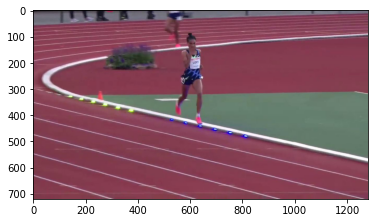

In [2]:
%matplotlib inline

import os
from PIL import Image

import sys
sys.path.append('../src')

from unreal_util import *
from projection_util import *
from mappings import *
from hough_util import *

img = np.array(Image.open('../figs/letesenbet_frame50.jpg'))
plt.imshow(img)

## 1. find lines and vanishing points

In [3]:
# determine vanishing points
from hough_util import *

plines, nplines = get_lines_for_img(img)

proto_segments = get_main_segments_from_lines(plines[:, 0, :])
for k, p in enumerate(proto_segments):
    proto_segments[k] = seg_to_full_width(img, p)

proto_seg = proto_segments.astype(int)[:, np.newaxis, :]
v0_det, v1_det = determine_vanish_points(proto_seg, nplines)

img = draw_lines_on_img(img, proto_seg, nplines)
midline = proto_seg[len(proto_seg)//2, 0, :]

# proto_segs[i] = proto_seg

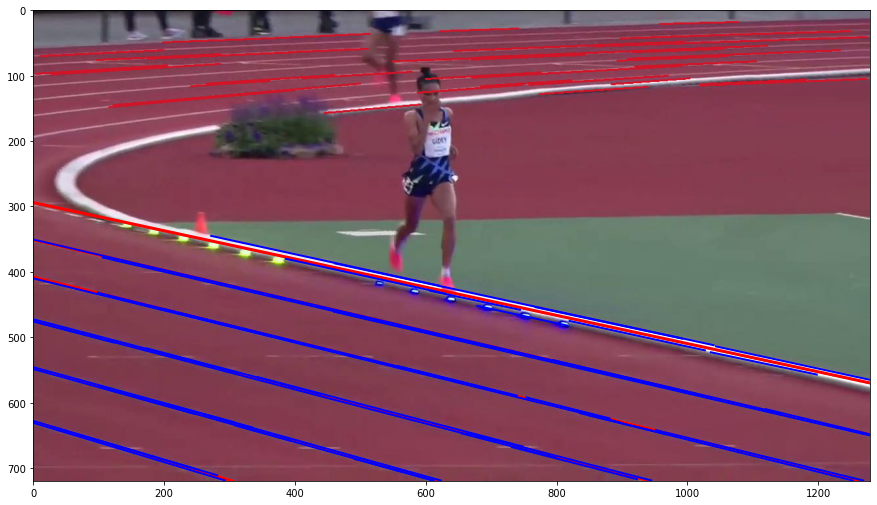

In [4]:
%matplotlib inline
from anim_util import *
# draw img to compare line segment predictions and our the groundtruth lines in the iamge.

proto = proto_seg
plt.figure(figsize=(15,10))

for p in proto:
    sp = p[0][:2].astype(int)
    ep = p[0][2:].astype(int)
    plt.plot(*np.vstack((sp, ep)).T, color='red', linewidth=3) 

for p in plines:
    sp = p[0][:2].astype(int)
    ep = p[0][2:].astype(int)
    plt.plot(*np.vstack((sp, ep)).T, color='blue', linewidth=2)
    
plt.imshow(img)

## 2. predict the sports field

In [5]:
# create a lookup grid for azim/elev pairs that could explain the VPs
ranges = {'azim': list(np.arange(-89, -1, 1)),
  'elev': list(np.arange(-25, -1, 1)),
  'dist': [50],
  'fov': [40],#list(np.arange(1, 10, 2)),
  'F': [1]#list(np.arange(1, 10, 2))
 }

no_roll = True

df_lookup = create_look_up_grid(ranges, no_roll)

100%|██████████| 2112/2112 [00:03<00:00, 634.76it/s]


In [6]:
# grab all posible azim&elev combinations for this VP
ind0, ind1 = 0, 4
proto_l0 = proto_segments[ind0]
proto_l1 = proto_segments[ind1]
v0_ = v0_det
v0 = [v0_[0], -v0_[1] + h]

azim_pairs = azim_from_v0_proto_no_shift(df_lookup, proto_l0, proto_l1, v0, k=k,
                        proj_indA=ind0, proj_indB=ind1, debug=True)

In [7]:
def trans_fun(x, h=720):
    x_out = x.copy()
    x_out[:, 1] = h - x_out[:, 1]
    return x_out

In [18]:
# interactive widget to explore the differnent possible camera parameters. 
# this cell needs to be rerun a couple of times sometimes to enable the full
# functionality o_O

%matplotlib widget
import ipywidgets as widgets

res_dict = None
plt.figure(figsize=(20, 10))
ax = plt.subplot(111)

@widgets.interact(cam_id=(0., 50., .1), x_off=(-40., 240.), target_height=(1, 15, .2))
def render_scene(cam_id=5.6, x_off=-3.1, target_height=9.35, use_height=False):
    ax.clear()
    
    image = img
    ax.imshow(image)
              
    best, cid_best = interpolate_params(azim_pairs['rds'], target_height)
    az_pair = interpolate(azim_pairs['rds'], cam_id)
        
    if use_height:
        print('best cam id', cid_best)
        az_pair = best
            
    # what 3d xshift do we have to perform to move
    rd0 = azim_pairs['rds'][0]
    rd0b = shift_x(rd0, x_off)
    p_start = get_lane1_marker(rd0b)
        
    p_cam = get_lane1_marker(az_pair)
    # the original marker in 3d from the new camera
    p_cam_3d = ray_cast_point(p_start, az_pair['cam_pos'], az_pair['image_plane'], z_off=0)
    p_cam_3db = ray_cast_point(p_cam, az_pair['cam_pos'], az_pair['image_plane'], z_off=0)
            
    # what is the distance to the lane1 marker in 3d from the
    x_off2 = p_cam_3db[0] - p_cam_3d[0]
    res_dict = shift_x(az_pair, x_off2)
    print(x_off, x_off2)
    
    lines2d = res_dict['lines_2ds'].copy()
    
    draw2d(ax, lines2d, res_dict['base_pts'], color='black', trans_fun=trans_fun, linewidth=3, alpha=.8)
       
    # also display the protosegs.
    for i, ps in enumerate(proto_seg):
        col = tab10(i)
        
        ax.plot(*ps[0].reshape(2,2).T, linewidth=4, alpha=.6, color=col)
        ax.text(*ps[0, :2], i)
        
    print('cam_vec', res_dict['cam_pos'])
    print('cam_rot', [res_dict['azim'], res_dict['elev'], res_dict['roll']])
    print('fov', res_dict['fov'])
    print('view_target', res_dict['view_target'])
    print('dist', res_dict['dist'])
    print('keys', res_dict.keys())
    print('v1', res_dict['v1'])
            
    ax.set_xlim(-500, 2000)
    ax.set_ylim(1000, -200)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=5.6, description='cam_id', max=50.0), FloatSlider(value=-3.1, descript…